In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import datajoint as dj
import neurodsp.filt
import scipy
from pathlib import Path
import numpy as np
import pywt
from scipy import signal

import utils.helper_func as hf
import utils.preprocessing as preprocessing
import utils.plotting as plotting

In [2]:
fs = 32768
#The resulting sample rate is up / down times the original sample rate.
up = 1
down=32
fs_downs = (up/down)*fs
start_time = 0
end_time = 1 #s
theta = 0

#time = np.arange(start_time, end_time, 1/fs_downs)
time = np.linspace(0, 1, num = np.int(1*fs_downs))

nperseg = 50 #window length
nfft = 100 #how many points for the FFT
noverlap = 40 #the number of overlapping samples between windows

#params   
w = 2.
num_freqs=140
min_freq = 1
max_freq = fs_downs/2
#min_freq = 2**(6/8)
#max_freq = 2**(54/8)

freq = np.linspace(min_freq, max_freq, num_freqs)
#freq = pywt.scale2frequency('cmor1.5-1.0', [1, 2, 3, 4]) / dt 
#freq = np.logspace(np.log10(min_freq),np.log10(max_freq),num_freqs)

widths = w*fs_downs / (2*freq*np.pi) #get wavelet width parameter at each frequency

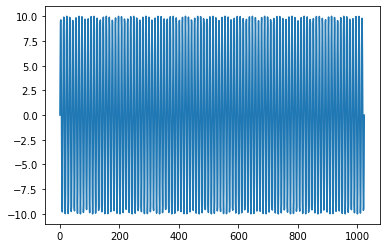

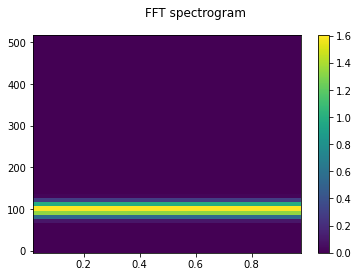

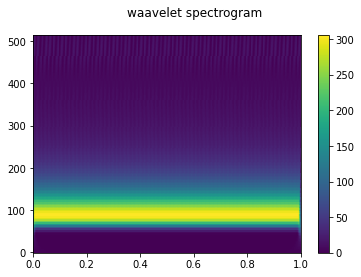

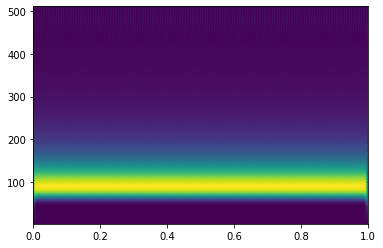

In [5]:
#only sine wave with frequency 100
epoch = 10 * np.sin(2 * np.pi * 100 * time + theta)
plt.plot(epoch)
freq_sp,time_sp,pwr = scipy.signal.spectrogram(epoch,fs_downs, window='hanning', nperseg=nperseg,
                                           nfft=nfft, noverlap=noverlap, detrend=False, scaling='density')
fig, ax = plt.subplots()
fig.suptitle('FFT spectrogram')
im = ax.pcolormesh(time_sp, freq_sp, pwr, shading='auto')
fig.colorbar(im)
plt.show()

cwtm = scipy.signal.cwt(epoch, scipy.signal.morlet2, widths, w=w)

fig, ax = plt.subplots()
fig.suptitle('wavelet spectrogram')
im = ax.pcolormesh(time, freq, np.abs(cwtm)**2, shading='auto')
fig.colorbar(im)
plt.show()

plt.pcolormesh(time, freq, np.abs(cwtm)**2, cmap='viridis', shading='gouraud')
plt.show()



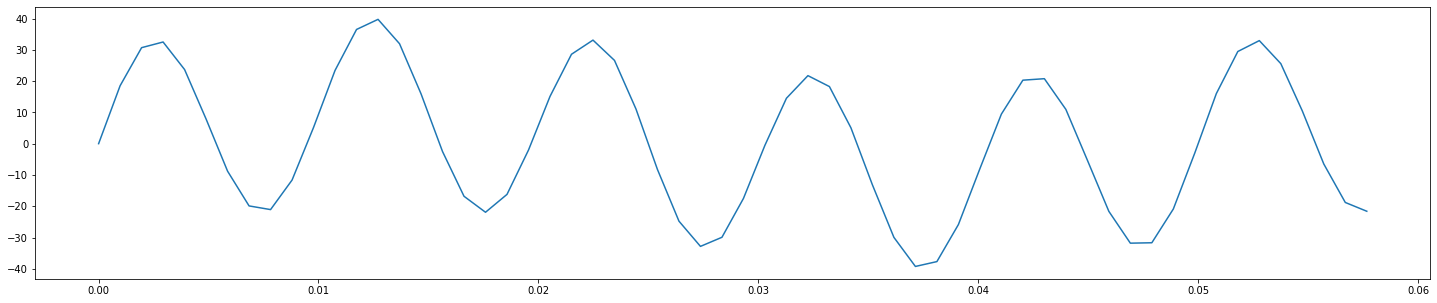

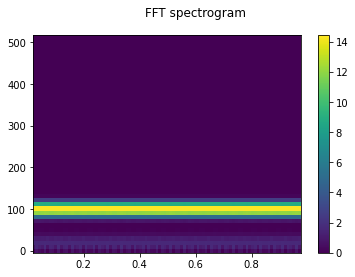

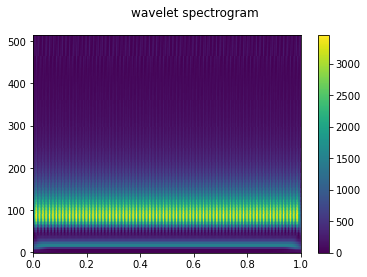

In [9]:
#2 sine waves with frequency 100 and 20
#frequency = [100,20,60,80]
#amplitude = [30,10,15,20]
frequency = [100,20]
amplitude = [30,10]

epoch_2 = np.zeros(len(time))
for i in range(len(frequency)):
    epoch_2 += amplitude[i] * np.sin(2 * np.pi * frequency[i] * time + theta)

fig = plt.figure(figsize=(25,5)) 
plt.plot(time[:60], epoch_2[:60])
plt.show()

freq_sp,time_sp,pwr = scipy.signal.spectrogram(epoch_2,fs_downs, window='hanning', nperseg=nperseg,
                                           nfft=nfft, noverlap=noverlap, detrend=False, scaling='density')
fig, ax = plt.subplots()
fig.suptitle('FFT spectrogram')
im = ax.pcolormesh(time_sp, freq_sp, pwr, shading='auto')
fig.colorbar(im) #cax=cax,
plt.show()

cwtm = scipy.signal.cwt(epoch_2, scipy.signal.morlet2, widths, w=w)

fig, ax = plt.subplots()
fig.suptitle('wavelet spectrogram')
im = ax.pcolormesh(time, freq, np.abs(cwtm)**2, shading='auto')
fig.colorbar(im)
plt.show()

In [16]:
top_dir = '/home/anastasia/epiphyte/anastasia/output'
folder = '04-spectrogram_wavelet'

patient_id = 46
session_nr = 1

signal_len = np.int(fs_downs*1.5)+1
times = np.linspace(-0.5, 1, signal_len)
times = times*1000

#params   
w = 2.
num_freqs=140
min_freq = 1
max_freq = fs_downs/2
#min_freq = 2**(6/8)
#max_freq = 2**(54/8)

freq = np.linspace(min_freq, max_freq, num_freqs)
#freq = pywt.scale2frequency('cmor1.5-1.0', [1, 2, 3, 4]) / dt 
#freq = np.logspace(np.log10(min_freq),np.log10(max_freq),num_freqs)

widths = w*fs / (2*freq*np.pi) #get wavelet width parameter at each frequency

idx = np.where(freq == hf.find_nearest(freq, 200))[0][0]
freq_less = freq[0:idx+1]

nperseg = 30 #window length
nfft = 200 #how many points for the FFT
noverlap = 15 #the number of overlapping samples between windows
signal_len = np.int(fs_downs*1.5)+1

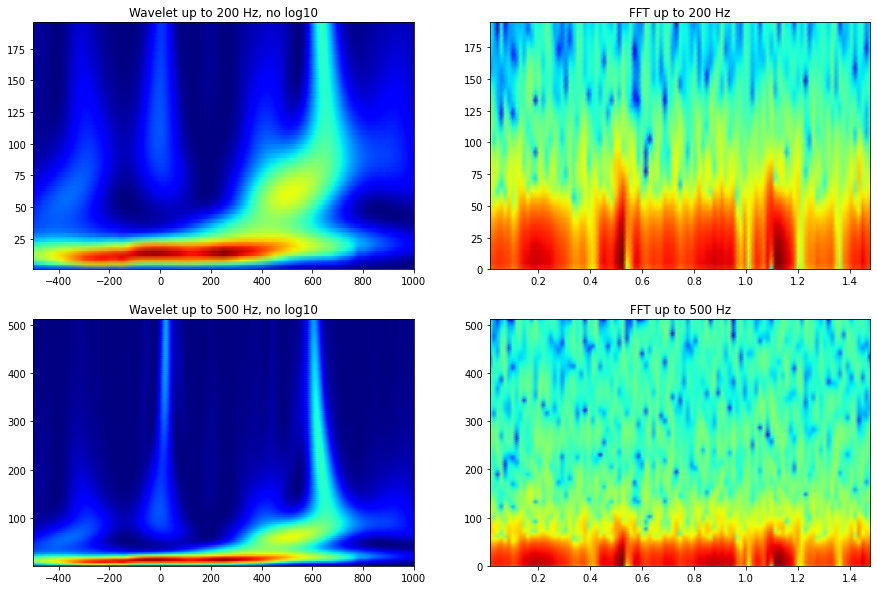

In [19]:
epochs = np.load(f'{top_dir}/01-preprocessed/epochs/broadband_2_sec/{patient_id}_epochs_channel-CSC1.npy')
pre_epoch = epochs[0, 512:]
estim = scipy.signal.cwt(pre_epoch, scipy.signal.morlet2, widths,w=w)
freq_sp,time_sp,pwr_sp = scipy.signal.spectrogram(pre_epoch,fs_downs, window='hanning', nperseg=nperseg,
                                                   nfft=nfft, noverlap=noverlap, detrend=False, scaling='density')
idx_sp = np.where(freq_sp == hf.find_nearest(freq_sp, 200))[0][0]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0,0].pcolormesh(times, freq[:idx], np.abs(estim[:idx,:])**2, cmap='jet', shading='gouraud')
axs[0,0].set_title('Wavelet up to 200 Hz, no log10')
axs[1,0].pcolormesh(times, freq, np.abs(estim)**2, cmap='jet', shading='gouraud')
axs[1,0].set_title('Wavelet up to 500 Hz, no log10')
axs[0,1].pcolormesh(time_sp, freq_sp[:idx_sp], np.log10(pwr_sp[:idx_sp,:]), cmap='jet', shading='gouraud')
axs[0,1].set_title('FFT up to 200 Hz')
axs[1,1].pcolormesh(time_sp, freq_sp, np.log10(pwr_sp), cmap='jet', shading='gouraud')
axs[1,1].set_title('FFT up to 500 Hz')
plt.show()
#estim = estim.shape

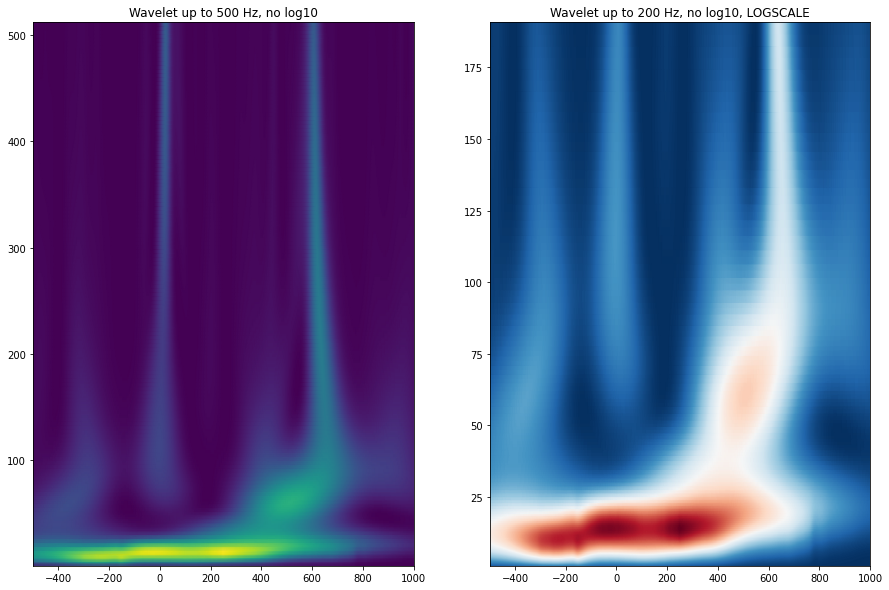

In [35]:
#use logscale
#https://www.jneurosci.org/content/29/43/13613
estim = scipy.signal.cwt(pre_epoch, scipy.signal.morlet2, widths,w=w)

#params   
w = 2.
num_freqs=140
min_freq = 1
max_freq = fs_downs/2
#min_freq = 2**(6/8)
#max_freq = 2**(54/8)

#freq = np.linspace(min_freq, max_freq, num_freqs)
#freq = pywt.scale2frequency('cmor1.5-1.0', [1, 2, 3, 4]) / dt 
freq2 = np.logspace(np.log10(min_freq),np.log10(max_freq),num_freqs)
idx2 = np.where(freq2 == hf.find_nearest(freq2, 200))[0][0]

widths2 = w*fs / (2*freq2*np.pi) #get wavelet width parameter at each frequency

estim2 = scipy.signal.cwt(pre_epoch, scipy.signal.morlet2, widths2,w=w)

idx_sp = np.where(freq_sp == hf.find_nearest(freq_sp, 200))[0][0]

fig, axs = plt.subplots(1,2,figsize=(15,10))
axs[0].pcolormesh(times, freq, np.abs(estim)**2, shading='gouraud')
axs[0].set_title('Wavelet up to 500 Hz, no log10')
#axs[1].pcolormesh(times, freq2[:idx2], np.log10(np.abs(estim2[:idx2,:])**2), cmap='RdBu_r', shading='gouraud')
axs[1].pcolormesh(times, freq2[:idx2], np.abs(estim2[:idx2,:])**2, cmap='RdBu_r', shading='gouraud')
axs[1].set_title('Wavelet up to 200 Hz, no log10, LOGSCALE')

plt.show()
#estim = estim.shape

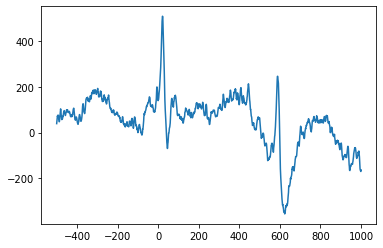

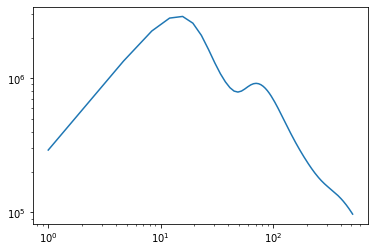

In [13]:
plt.plot(times,pre_epoch);
plt.show()
plt.loglog(freq, np.mean((np.abs(estim)**2), axis=1));
plt.show()